## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import requests
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

df = pd.read_csv('data/kc_house_data.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [3]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
#********************PRICE FILTER**********************


# df = df[df['price'] < 2000000]
df = df[(df['sqft_living'] < 4000) & (df['price'] < 2000000)]

# df_2 = df[df['sqft_living'] < 4000]

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [7]:
print('Earliest Sale:', df['date'].min())
print('Latest Sale:', df['date'].max())

Earliest Sale: 2021-06-10 00:00:00
Latest Sale: 2022-06-09 00:00:00


In [8]:
df['year'].value_counts()

2021    17730
2022     9587
Name: year, dtype: int64

<AxesSubplot:ylabel='Frequency'>

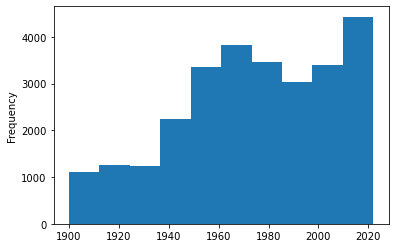

In [9]:
df['yr_built'].plot.hist()

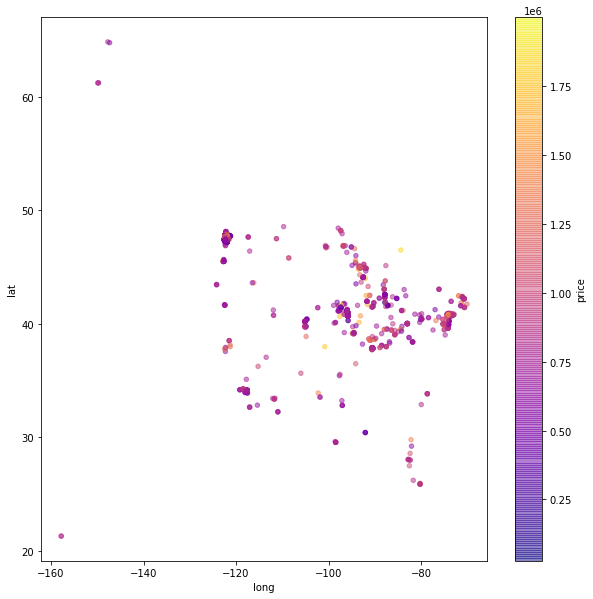

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
df.plot.scatter(x="long", y="lat", c="price", cmap="plasma", alpha=0.5, ax=ax);

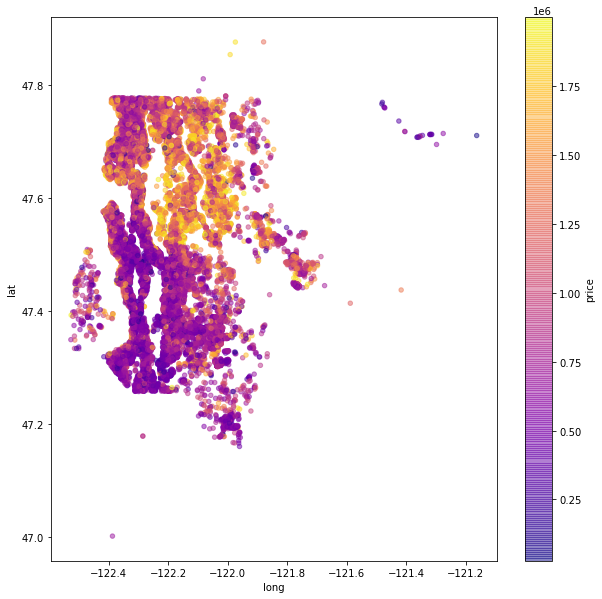

In [11]:
df_zoom = df[(df['lat'] > 47) & (df['lat'] < 48) & (df['long'] > -130) & (df['long'] < -120)]

fig, ax = plt.subplots(figsize=(10,10))
df_zoom.plot.scatter(x="long", y="lat", c="price", cmap="plasma", alpha=0.5, ax=ax);


In [12]:
df[['Street', 'City', 'State_Zip', 'Country', 'Extra_1', 'Extra_2']] = df['address'].str.split(',', expand = True)

In [13]:
df['zip'] = df.apply(lambda row: row['State_Zip'][-5:], axis=1)

In [14]:
# df = df[df.zip != 'City']

df = df[~df['zip'].str.contains("[a-zA-Z]").fillna(False)]
#INVESTIGATE WHY THIS WORKS

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27232 entries, 0 to 30154
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             27232 non-null  int64         
 1   date           27232 non-null  datetime64[ns]
 2   price          27232 non-null  float64       
 3   bedrooms       27232 non-null  int64         
 4   bathrooms      27232 non-null  float64       
 5   sqft_living    27232 non-null  int64         
 6   sqft_lot       27232 non-null  int64         
 7   floors         27232 non-null  float64       
 8   waterfront     27232 non-null  object        
 9   greenbelt      27232 non-null  object        
 10  nuisance       27232 non-null  object        
 11  view           27232 non-null  object        
 12  condition      27232 non-null  object        
 13  grade          27232 non-null  object        
 14  heat_source    27232 non-null  object        
 15  sewer_system   2723

In [16]:
df = df[df['zip'].map(df['zip'].value_counts()) > 100]

In [17]:
len(df)

25883

In [18]:
df_zip_mean = df.groupby('zip', as_index=False).mean()

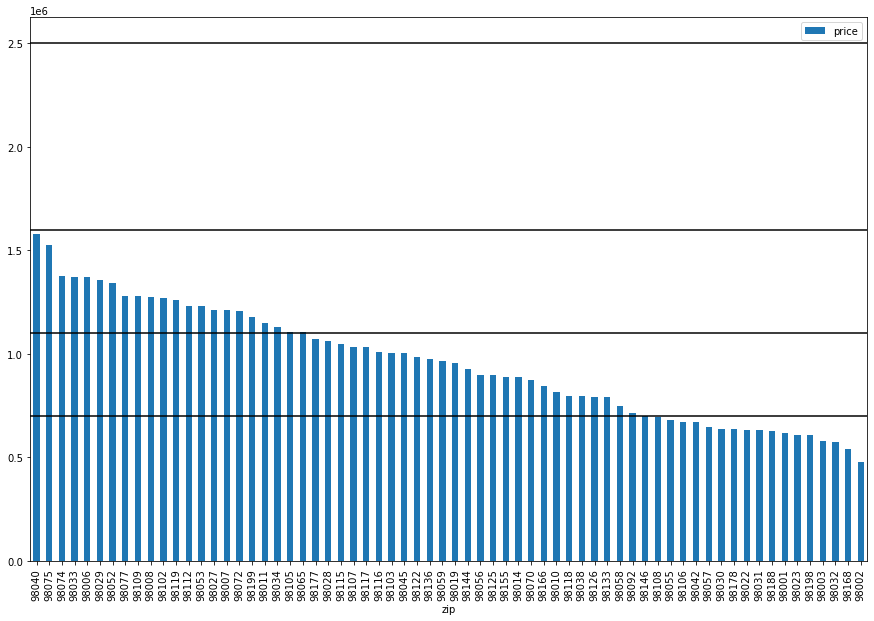

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))

# df.groupby('zip').mean().sort_values('price', ascending=False)['price']
df.groupby('zip').mean().sort_values('price', ascending=False).plot.bar(y='price', ax=ax);
plt.axhline(2500000, color='black')
plt.axhline(1600000, color='black')
plt.axhline(1100000, color='black')
plt.axhline(700000, color='black')

In [20]:
def label_zip (row):   
    if row['price'] > 2500000:
        return "Tier_1_zip"
    if (row['price'] < 2500000) & (row['price'] > 1600000):
        return "Tier_2_zip"
    if (row['price'] < 1600000) & (row['price'] > 1100000):
        return "Tier_3_zip"
    if (row['price'] < 1100000) & (row['price'] > 700000):
        return "Tier_4_zip"
    if row['price'] < 700000:
        return "Tier_5_zip"
    
df_zip_mean['zip_tier'] = df_zip_mean.apply(lambda row: label_zip(row), axis=1)
df_zip_mean

,zip,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,year,zip_tier
0,98001,4.510323e+09,6.166923e+05,3.528090,2.245586,2034.064205,14882.226324,1.471108,1873.264848,253.547352,408.648475,194.914928,1982.995185,44.807384,47.312228,-122.272730,2021.343499,Tier_5_zip
1,98002,4.819624e+09,4.754262e+05,3.228650,1.822314,1543.438017,8360.512397,1.271350,1447.600551,198.966942,252.909091,104.148760,1962.134986,99.391185,47.305168,-122.213713,2021.399449,Tier_5_zip
2,98003,4.542007e+09,5.779452e+05,3.530892,2.226545,1923.819222,11278.400458,1.324943,1654.675057,378.606407,394.748284,204.826087,1975.931350,50.240275,47.317416,-122.313205,2021.366133,Tier_5_zip
3,98006,4.569746e+09,1.370329e+06,3.773256,2.543605,2334.761628,12584.447674,1.300872,1817.683140,672.790698,432.020349,243.488372,1973.139535,75.883721,47.558644,-122.154950,2021.296512,Tier_3_zip
4,98007,4.688798e+09,1.209404e+06,3.757576,2.215909,1955.492424,10281.143939,1.204545,1623.257576,428.409091,337.924242,203.333333,1964.984848,106.507576,47.603126,-122.140496,2021.356061,Tier_3_zip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,98177,4.064954e+09,1.072585e+06,3.438462,2.175000,2086.903846,9647.373077,1.253846,1620.519231,696.423077,294.346154,208.657692,1956.142308,130.538462,47.738554,-122.368084,2021.326923,Tier_4_zip
62,98178,4.254656e+09,6.375954e+05,3.235450,1.821429,1727.746032,9203.851852,1.193122,1346.846561,597.936508,187.724868,133.314815,1955.108466,142.886243,47.498617,-122.248000,2021.378307,Tier_5_zip
63,98188,4.048284e+09,6.294376e+05,3.255000,1.965000,1828.700000,11481.005000,1.252500,1563.800000,425.250000,284.310000,165.860000,1963.340000,118.945000,47.448735,-122.280329,2021.335000,Tier_5_zip
64,98198,5.134786e+09,6.061487e+05,3.367299,2.062796,1775.829384,9663.872038,1.227488,1491.947867,433.457346,319.841232,210.594787,1970.071090,85.322275,47.390072,-122.315046,2021.381517,Tier_5_zip


In [21]:
df_zip_mean = df_zip_mean[['zip', 'zip_tier']]
df_zip_mean

,zip,zip_tier
0,98001,Tier_5_zip
1,98002,Tier_5_zip
2,98003,Tier_5_zip
3,98006,Tier_3_zip
4,98007,Tier_3_zip
...,...,...
61,98177,Tier_4_zip
62,98178,Tier_5_zip
63,98188,Tier_5_zip
64,98198,Tier_5_zip


In [22]:
df = df_zip_mean.merge(df, how='inner', 
                                    left_on='zip', 
                                    right_on='zip')

df.head()

,zip,zip_tier,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,address,lat,long,year,Street,City,State_Zip,Country,Extra_1,Extra_2
0,98001,Tier_5_zip,2595650230,2022-04-13,770000.0,4,2.5,1980,13216,2.0,...,"27805 50th Place South, Auburn, Washington 980...",47.35278,-122.271610,2022,27805 50th Place South,Auburn,Washington 98001,United States,None,None
1,98001,Tier_5_zip,3751602968,2021-09-07,725000.0,3,2.5,2110,23060,2.0,...,"4642 South 358th Street, Auburn, Washington 98...",47.28116,-122.274460,2021,4642 South 358th Street,Auburn,Washington 98001,United States,None,None
2,98001,Tier_5_zip,6144000040,2021-06-16,471513.0,3,2.5,2060,12679,1.0,...,"3924 South 325th Place, Federal Way, Washingto...",47.31014,-122.283170,2021,3924 South 325th Place,Federal Way,Washington 98001,United States,None,None
3,98001,Tier_5_zip,5647900050,2021-09-10,450000.0,3,2.5,1910,8768,1.0,...,"2221 W Street Northwest, Auburn, Washington 98...",47.32775,-122.260100,2021,2221 W Street Northwest,Auburn,Washington 98001,United States,None,None
4,98001,Tier_5_zip,1312000060,2022-02-15,555000.0,3,1.5,1250,7380,1.0,...,"28807 41st Avenue South, Auburn, Washington 98...",47.34257,-122.282495,2022,28807 41st Avenue South,Auburn,Washington 98001,United States,None,None


In [23]:
df.columns

Index(['zip', 'zip_tier', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt',
       'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'year', 'Street', 'City',
       'State_Zip', 'Country', 'Extra_1', 'Extra_2'],
      dtype='object')

In [24]:
len(df)

25883

In [25]:
df.drop(['Extra_1', 'Extra_2', 'Country', 'State_Zip', 'Street', 'City', 'address'], axis=1, inplace=True)

In [26]:
df.columns

Index(['zip', 'zip_tier', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt',
       'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'year'],
      dtype='object')

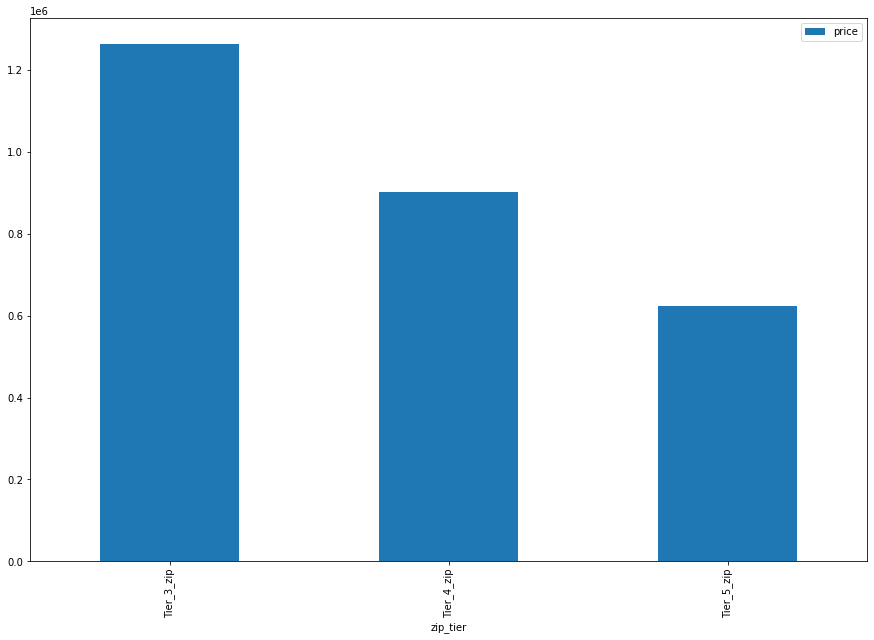

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))

# df.groupby('zip').mean().sort_values('price', ascending=False)['price']
df.groupby('zip_tier').mean().sort_values('price', ascending=False).plot.bar(y='price', ax=ax);

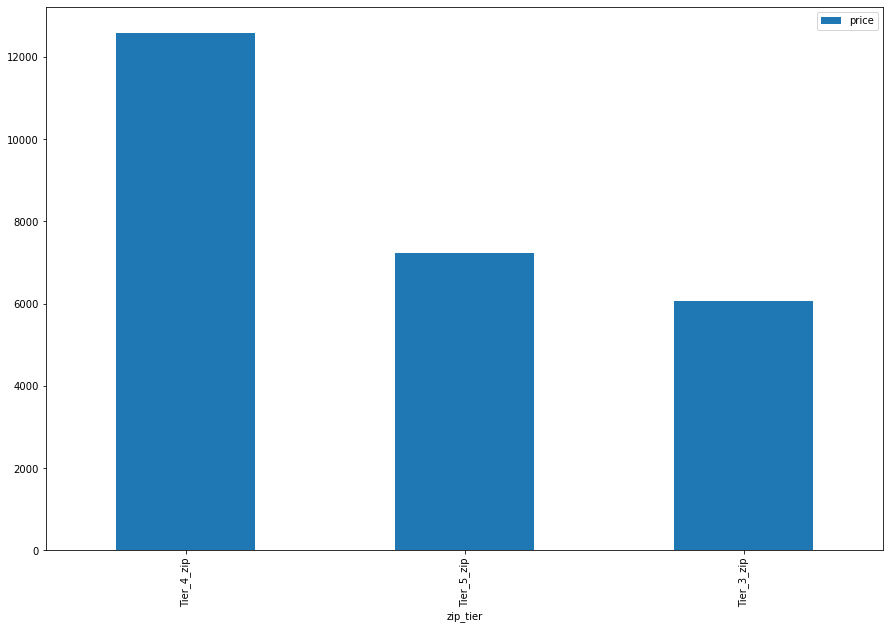

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

df.groupby('zip_tier').count().sort_values('price', ascending=False).plot.bar(y='price', ax=ax);

In [29]:
df['zip_tier'].value_counts(normalize=True)

Tier_4_zip    0.486420
Tier_5_zip    0.279063
Tier_3_zip    0.234517
Name: zip_tier, dtype: float64

In [30]:
def label_grade (row):
    if row["grade"] in ["2 Substandard", "3 Poor", "5 Fair", "4 Low", "6 Low Average"]:
        return "2 Substd. - 6 Low Ave."
    if row["grade"] in ["7 Average", "8 Good"]:
        return "7 Ave. - 8 Good"
    if row["grade"] in ["9 Better", "10 Very Good"]:
        return "9 Better - 10 Very Gd."
    if row["grade"] in ["11 Excellent", "12 Luxary", "13 Mansion"]:
        return "11 Ex - 13 Masion"
    
df['grade_group'] = df.apply(lambda row: label_grade(row), axis=1)

<AxesSubplot:xlabel='grade_group'>

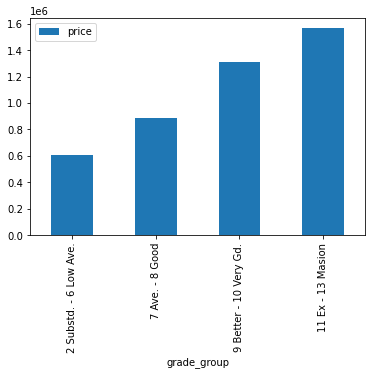

In [31]:
df.groupby("grade_group").mean().sort_values(by='price').plot.bar(y="price")

<AxesSubplot:xlabel='grade_group'>

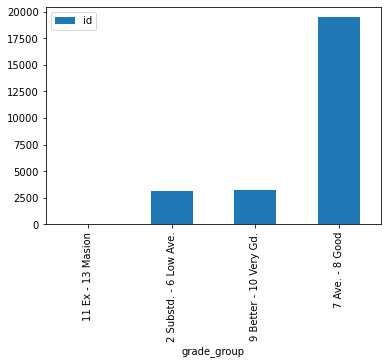

In [32]:
df.groupby("grade_group").count().sort_values(by='price').plot.bar(y='id')

In [33]:
df['yr_renovated'].value_counts()

0       24811
2021       63
2018       38
2004       34
1990       32
        ...  
1946        1
1942        1
1948        1
1972        1
1966        1
Name: yr_renovated, Length: 82, dtype: int64

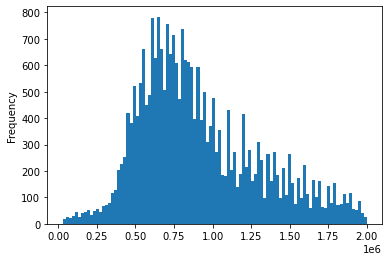

In [34]:
df["price"].plot.hist(bins=100);

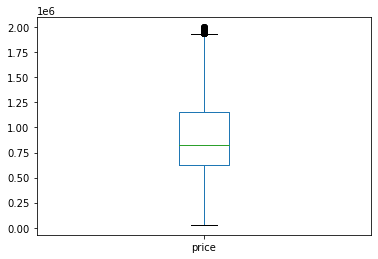

In [35]:
df["price"].plot.box();

Add exploratory of other variables used

In [36]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,year
count,2.588300e+04,2.588300e+04,25883.000000,25883.000000,25883.000000,2.588300e+04,25883.000000,25883.000000,25883.000000,25883.000000,25883.000000,25883.000000,25883.000000,25883.000000,25883.000000,25883.000000
mean,4.582997e+09,9.083339e+05,3.361280,2.219488,1968.290268,1.504476e+04,1.489259,1691.057914,452.352432,314.365066,195.011629,1972.757988,82.743693,47.536037,-122.219602,2021.352239
std,2.878285e+09,3.901103e+05,0.944374,0.786069,770.419053,4.899943e+04,0.546413,719.136890,542.455641,267.788542,219.190292,31.537978,398.096282,0.149546,0.142018,0.477677
min,1.000055e+06,2.756300e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.159700,-122.526650,2021.000000
25%,2.130405e+09,6.250000e+05,3.000000,2.000000,1400.000000,4.875000e+03,1.000000,1160.000000,0.000000,0.000000,30.000000,1951.000000,0.000000,47.406328,-122.334470,2021.000000
50%,3.904100e+09,8.220000e+05,3.000000,2.500000,1860.000000,7.350000e+03,1.000000,1500.000000,0.000000,380.000000,130.000000,1975.000000,0.000000,47.543080,-122.256930,2021.000000
75%,7.302550e+09,1.150000e+06,4.000000,2.500000,2430.000000,1.008700e+04,2.000000,2100.000000,920.000000,500.000000,290.000000,1999.000000,0.000000,47.673180,-122.131798,2022.000000
max,9.904000e+09,1.999999e+06,11.000000,7.500000,8020.000000,2.657160e+06,4.000000,6630.000000,3560.000000,2840.000000,2880.000000,2022.000000,2022.000000,47.789830,-121.417590,2022.000000


In [37]:
df['bedrooms'] = df['bedrooms'].map(str)
df['bathrooms'] = df['bathrooms'].map(str)
df['floors'] = df['floors'].map(str)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25883 entries, 0 to 25882
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip            25883 non-null  object        
 1   zip_tier       25883 non-null  object        
 2   id             25883 non-null  int64         
 3   date           25883 non-null  datetime64[ns]
 4   price          25883 non-null  float64       
 5   bedrooms       25883 non-null  object        
 6   bathrooms      25883 non-null  object        
 7   sqft_living    25883 non-null  int64         
 8   sqft_lot       25883 non-null  int64         
 9   floors         25883 non-null  object        
 10  waterfront     25883 non-null  object        
 11  greenbelt      25883 non-null  object        
 12  nuisance       25883 non-null  object        
 13  view           25883 non-null  object        
 14  condition      25883 non-null  object        
 15  grade          2588

sqft living looks to be above and below ground. Prelim analysis

In [39]:
df_num = df.select_dtypes(include=np.number).drop(['id', 'lat', 'long'], axis=1)

In [40]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25883 entries, 0 to 25882
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          25883 non-null  float64
 1   sqft_living    25883 non-null  int64  
 2   sqft_lot       25883 non-null  int64  
 3   sqft_above     25883 non-null  int64  
 4   sqft_basement  25883 non-null  int64  
 5   sqft_garage    25883 non-null  int64  
 6   sqft_patio     25883 non-null  int64  
 7   yr_built       25883 non-null  int64  
 8   yr_renovated   25883 non-null  int64  
 9   year           25883 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.2 MB


In [41]:
y_scatter = df_num['price']
X_scatter = df_num.drop('price', axis=1)

Dropping bedrooms and bathrooms...assuming categorical

<bound method Figure.tight_layout of <Figure size 1080x1080 with 16 Axes>>

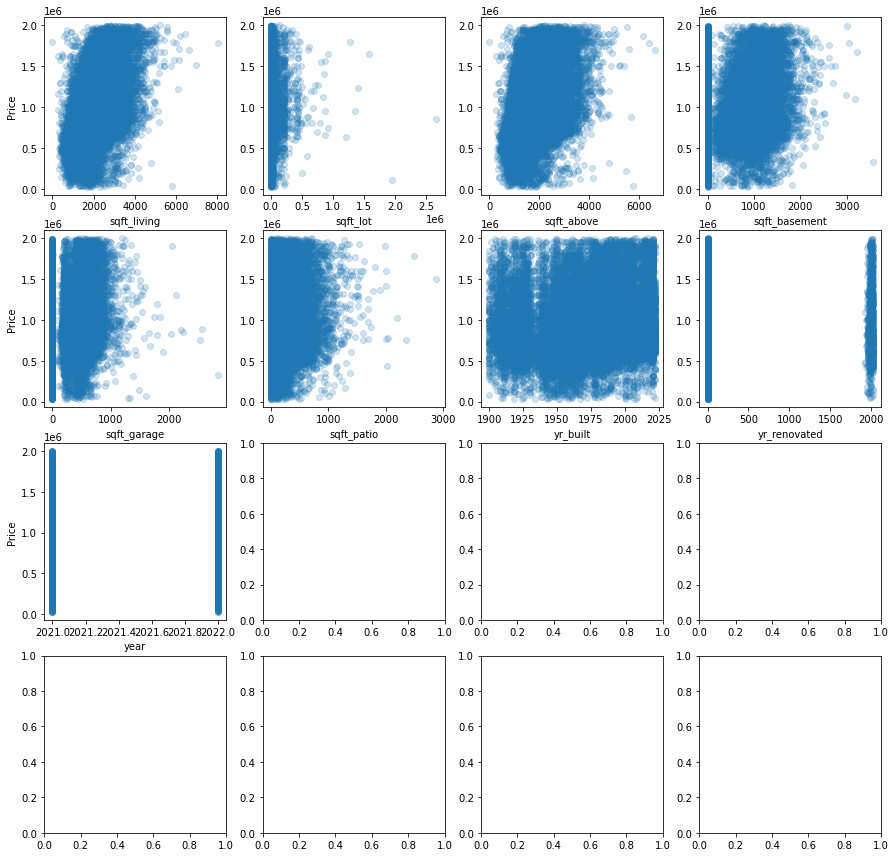

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

for i, column in enumerate(X_scatter.columns):
    row = i // 4
    col = i % 4
    ax = axes[row][col]
    
    ax.scatter(X_scatter[column], y_scatter, alpha=0.2);
    ax.set_xlabel(column)
    if col == 0:
        ax.set_ylabel('Price')
        
fig.tight_layout

In [43]:
numerical_rank = df_num.corr()["price"].sort_values(ascending=False)
numerical_rank

price            1.000000
sqft_living      0.532070
sqft_above       0.440739
sqft_patio       0.228824
sqft_garage      0.209627
sqft_basement    0.207247
year             0.086733
yr_built         0.074290
sqft_lot         0.067570
yr_renovated     0.051383
Name: price, dtype: float64

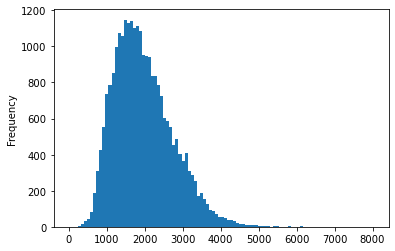

In [44]:
df["sqft_living"].plot.hist(bins=100);

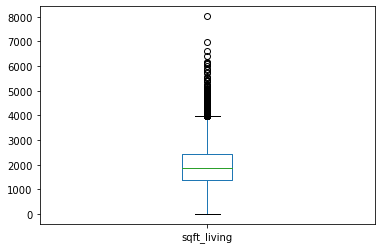

In [45]:
df["sqft_living"].plot.box();

In [46]:
X_baseline = df[['sqft_living']]
y = df['price']

model_baseline = sm.OLS(y, sm.add_constant(X_baseline))
results_baseline = model_baseline.fit()

print(results_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 1.022e+04
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:13:21   Log-Likelihood:            -3.6564e+05
No. Observations:               25883   AIC:                         7.313e+05
Df Residuals:                   25881   BIC:                         7.313e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         3.78e+05   5633.016     67.111      

In [47]:
X_quad = X_baseline.copy()
X_quad

,sqft_living
0,1980
1,2110
2,2060
3,1910
4,1250
...,...
25878,1570
25879,3070
25880,1190
25881,2540


In [48]:
X_quad['sqft_sq'] = X_quad['sqft_living']**2

model_quad = sm.OLS(y, sm.add_constant(X_quad))
results_quad = model_quad.fit()

print(results_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     5149.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:13:21   Log-Likelihood:            -3.6561e+05
No. Observations:               25883   AIC:                         7.312e+05
Df Residuals:                   25880   BIC:                         7.313e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.017e+05   1.17e+04     25.789      

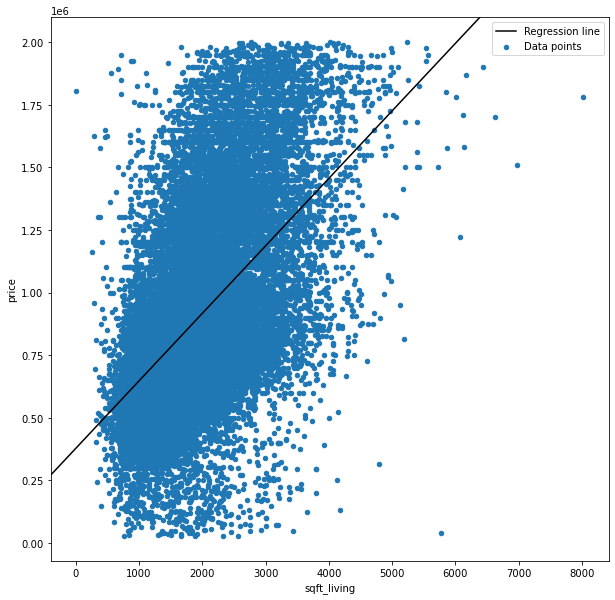

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
df.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=results_baseline, label="Regression line", ax=ax, color="black");
ax.legend()

In [50]:
len(results_baseline.resid)

25883

In [51]:
len(df["sqft_living"])

25883

In [52]:
len(df_num)

25883

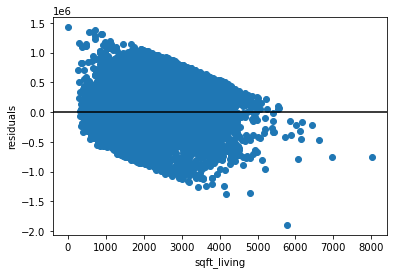

In [53]:
fig, ax = plt.subplots()

ax.scatter(df["sqft_living"], results_baseline.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

Add visualizations of model and best fit line

Potentially add grade if needed

In [54]:
categoricals = df.select_dtypes("object")
categoricals.columns


Index(['zip', 'zip_tier', 'bedrooms', 'bathrooms', 'floors', 'waterfront',
       'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source',
       'sewer_system', 'grade_group'],
      dtype='object')

In [55]:
pd.set_option('display.max_rows', None)
for col in categoricals:
    print(df[col].value_counts(), "\n")

98042    992
98038    852
98103    728
98117    722
98115    696
98023    692
98058    679
98133    664
98034    631
98001    623
98092    607
98118    584
98059    554
98106    543
98031    529
98155    504
98056    499
98125    475
98052    459
98022    454
98045    449
98107    445
98003    437
98126    433
98198    422
98146    420
98144    410
98122    399
98168    383
98178    378
98030    376
98002    363
98116    360
98028    345
98006    344
98008    339
98033    338
98027    334
98166    333
98199    319
98074    315
98010    310
98108    303
98053    303
98072    295
98136    292
98029    279
98065    278
98105    270
98177    260
98011    249
98075    247
98019    242
98055    218
98112    207
98119    201
98188    200
98077    187
98032    183
98070    180
98014    148
98007    132
98057    127
98040    126
98102    114
98109    103
Name: zip, dtype: int64 

Tier_4_zip    12590
Tier_5_zip     7223
Tier_3_zip     6070
Name: zip_tier, dtype: int64 

3     11568
4      8061
2

In [56]:
categoricals.columns

Index(['zip', 'zip_tier', 'bedrooms', 'bathrooms', 'floors', 'waterfront',
       'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source',
       'sewer_system', 'grade_group'],
      dtype='object')

In [57]:
cat_features = categoricals.columns

In [58]:
# fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 30))

# for index, feature in enumerate(cat_features):
#     row = index//3
#     col = index%3
#     df.groupby(feature).mean().sort_values(by='price').plot.bar(y="price", ax=ax[row][col])

# fig.tight_layout

UPDATE CHART ABOVE TO COVER FULL ALL 11 CHARTS (WITH ZIP TIER)

In [59]:
X_1 = df[['sqft_living', 'zip_tier']]
X_1 = pd.get_dummies(X_1, columns = ['zip_tier'])

# y = df['price']

X_1.head()

,sqft_living,zip_tier_Tier_3_zip,zip_tier_Tier_4_zip,zip_tier_Tier_5_zip
0,1980,0,0,1
1,2110,0,0,1
2,2060,0,0,1
3,1910,0,0,1
4,1250,0,0,1


In [60]:
X_1.drop(['zip_tier_Tier_4_zip'], axis=1, inplace=True)

model_1 = sm.OLS(y, sm.add_constant(X_1))
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                 1.052e+04
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:13:22   Log-Likelihood:            -3.5963e+05
No. Observations:               25883   AIC:                         7.193e+05
Df Residuals:                   25879   BIC:                         7.193e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 4.56e+05   4

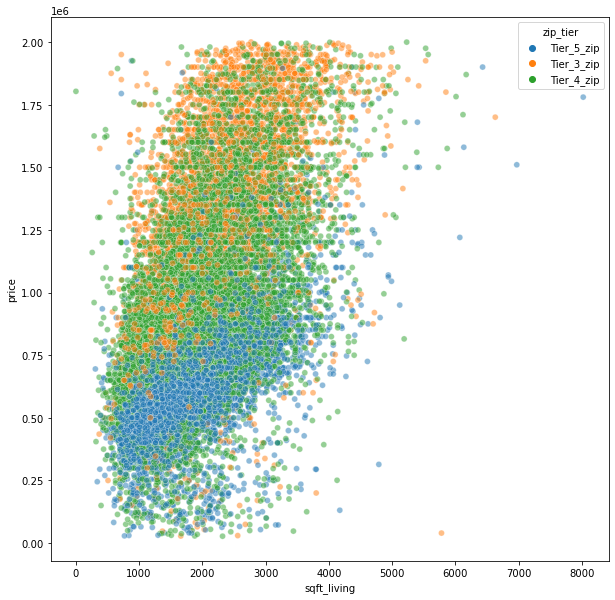

In [61]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='sqft_living', y='price', data=df, hue='zip_tier', alpha=.5);

In [62]:
X_1_inter = df[['sqft_living', 'zip_tier']]
X_1_inter = pd.get_dummies(X_1_inter, columns = ['zip_tier'])
X_1_inter.head()

,sqft_living,zip_tier_Tier_3_zip,zip_tier_Tier_4_zip,zip_tier_Tier_5_zip
0,1980,0,0,1
1,2110,0,0,1
2,2060,0,0,1
3,1910,0,0,1
4,1250,0,0,1


In [63]:
X_1_inter['sqft x Tier 3'] = X_1_inter['sqft_living'] * X_1_inter['zip_tier_Tier_3_zip']

In [66]:
# X_1_inter.drop('zip_tier_Tier_5_zip', axis=1, inplace=True)

model_1_inter = sm.OLS(y, sm.add_constant(X_1_inter))
results_1_inter = model_1_inter.fit()
print(results_1_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     8017.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:14:09   Log-Likelihood:            -3.5952e+05
No. Observations:               25883   AIC:                         7.190e+05
Df Residuals:                   25878   BIC:                         7.191e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.204e+05   5

In [65]:
y_pred_1_inter = results_1_inter.predict(sm.add_constant(X_1_inter))
mean_absolute_error(y, y_pred_1_inter)

185408.23522167926

Potentially look at interaction term, waterfront, view (and maybe bedrooms??), renovated (yes/no). You could at least have a section where you explain why you didn't look at these

In [66]:
y_pred_1 = results_1.predict(sm.add_constant(X_1))
mean_absolute_error(y, y_pred_1)

188311.50483998974

In [67]:
mean_squared_error(y, y_pred_1, squared=False)

255409.43257288795

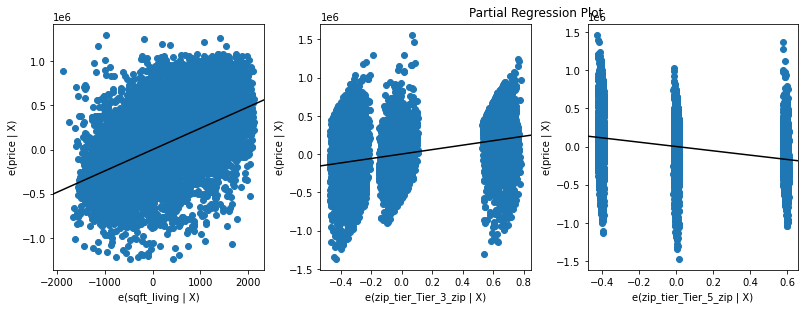

In [68]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_1,
    exog_idx=list(X_1.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

Multicolinearity: this an issue with categorical data?

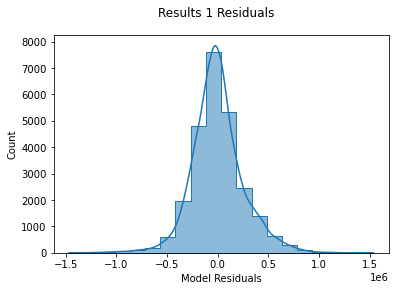

In [69]:
fig, ax = plt.subplots()
sns.histplot(results_1.resid, bins=20, element="step", kde=True, ax=ax)
ax.set_xlabel("Model Residuals")
fig.suptitle("Results 1 Residuals");

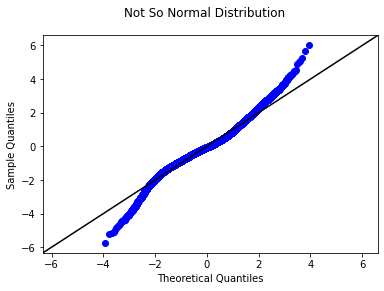

In [70]:
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(results_1.resid, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
line = ax.lines[1]
line.set_color("black")
fig.suptitle("Not So Normal Distribution");

In [71]:
jarque_bera(results_1.resid)
#Reject null hypothesis...it is NOT normal

(3898.4236464990477, 0.0, 0.22578685904976087, 4.859995371804782)

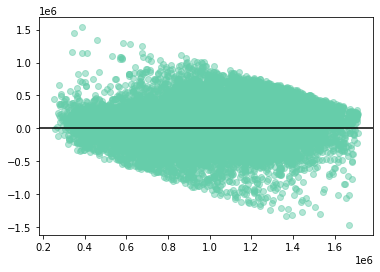

In [72]:
fig, ax = plt.subplots()
ax.scatter(y=results_1.resid, x=y_pred_1, color="mediumaquamarine", alpha=0.5)
ax.axhline(y=0, color="black")


Is this residual plot right?

Is the formula below correct?

In [73]:
het_breuschpagan(results_1.resid, sm.add_constant(X_1))

(1202.5619561842634,
 2.0386544739411422e-260,
 420.5959187053726,
 1.0071620069363206e-266)

In [74]:
X_2 = df[['sqft_living', 'zip_tier', 'view']]
X_2 = pd.get_dummies(X_2, columns = ['zip_tier', 'view'])

# y = df['price']

X_2.head()

,sqft_living,zip_tier_Tier_3_zip,zip_tier_Tier_4_zip,zip_tier_Tier_5_zip,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,1980,0,0,1,0,0,0,0,1
1,2110,0,0,1,0,0,0,0,1
2,2060,0,0,1,0,0,0,0,1
3,1910,0,0,1,0,0,0,0,1
4,1250,0,0,1,0,0,0,0,1


In [75]:
X_2.drop(['zip_tier_Tier_4_zip', 'view_NONE'], axis=1, inplace=True)

model_2 = sm.OLS(y, sm.add_constant(X_2))
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     4897.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:11:01   Log-Likelihood:            -3.5380e+05
No. Observations:               25539   AIC:                         7.076e+05
Df Residuals:                   25531   BIC:                         7.077e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 4.59e+05   4

In [76]:
y_pred_2 = results_2.predict(sm.add_constant(X_2))
mean_absolute_error(y, y_pred_2)

185220.83797010238

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25539 entries, 0 to 25538
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip            25539 non-null  object        
 1   zip_tier       25539 non-null  object        
 2   id             25539 non-null  int64         
 3   date           25539 non-null  datetime64[ns]
 4   price          25539 non-null  float64       
 5   bedrooms       25539 non-null  object        
 6   bathrooms      25539 non-null  object        
 7   sqft_living    25539 non-null  int64         
 8   sqft_lot       25539 non-null  int64         
 9   floors         25539 non-null  object        
 10  waterfront     25539 non-null  object        
 11  greenbelt      25539 non-null  object        
 12  nuisance       25539 non-null  object        
 13  view           25539 non-null  object        
 14  condition      25539 non-null  object        
 15  grade          2553

In [78]:
X_3 = df[['sqft_living', 'zip_tier', 'grade_group']]
X_3 = pd.get_dummies(X_3, columns = ['zip_tier', 'grade_group'])

# y = df['price']

X_3.head()

,sqft_living,zip_tier_Tier_3_zip,zip_tier_Tier_4_zip,zip_tier_Tier_5_zip,grade_group_11 Ex - 13 Masion,grade_group_2 Substd. - 6 Low Ave.,grade_group_7 Ave. - 8 Good,grade_group_9 Better - 10 Very Gd.
0,1980,0,0,1,0,0,1,0
1,2110,0,0,1,0,0,1,0
2,2060,0,0,1,0,0,1,0
3,1910,0,0,1,0,0,1,0
4,1250,0,0,1,0,0,1,0


In [79]:
X_3.drop(['zip_tier_Tier_4_zip', 'grade_group_2 Substd. - 6 Low Ave.'], axis=1, inplace=True)

model_3 = sm.OLS(y, sm.add_constant(X_3))
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     5717.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:11:14   Log-Likelihood:            -3.5380e+05
No. Observations:               25539   AIC:                         7.076e+05
Df Residuals:                   25532   BIC:                         7.077e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [80]:
y_pred_3 = results_3.predict(sm.add_constant(X_3))
mean_absolute_error(y, y_pred_3)

184340.3759735293

In [81]:
OLD WORK

SyntaxError: invalid syntax (<ipython-input-81-0fb937e15c39>, line 1)

In [82]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import requests


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,year
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397,2021.360206
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475,0.480068
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480,2021.000000
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045,2021.000000
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585,2021.000000
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205,2022.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340,2022.000000


<AxesSubplot:ylabel='Frequency'>

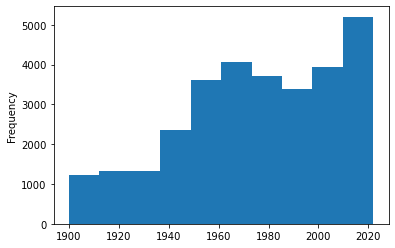

2021    19293
2022    10862
Name: year, dtype: int64

Earliest Sale: 2021-06-10 00:00:00
Latest Sale: 2022-06-09 00:00:00


In [10]:
# def label_hood (row):
#     try:
#         url = "https://api.mapbox.com/geocoding/v5/mapbox.places/{},{}.json?types=neighborhood&access_token=pk.eyJ1IjoicHBhcmtpbnNvbiIsImEiOiJjbGJ6cDR3eW8xMndtM3BwajU5ZGIwbjd3In0.krj0bzOrWhxQiEHZ2w5-IQ".format(df['long'], df['lat'])
#         response = requests.get(url)
#         return response.json()['features'][0]['text']
#     except (ValueError, TypeError):
#         continue
    
# df['neighborhood'] = df.apply(lambda row: label_hood(row), axis=1)

In [11]:
df['view'].value_counts()

NONE         26589
AVERAGE       1915
GOOD           878
EXCELLENT      553
FAIR           220
Name: view, dtype: int64

In [12]:
df['condition'].value_counts()

Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64

In [13]:
df['grade'].value_counts()

7 Average        11697
8 Good            9410
9 Better          3806
6 Low Average     2858
10 Very Good      1371
11 Excellent       406
5 Fair             393
12 Luxury          122
4 Low               51
13 Mansion          24
3 Poor              13
1 Cabin              2
2 Substandard        2
Name: grade, dtype: int64

In [14]:
df['yr_renovated'].value_counts()

0       28783
2021       69
2006       49
2018       44
1990       42
        ...  
1924        1
1942        1
1972        1
1951        1
1930        1
Name: yr_renovated, Length: 83, dtype: int64

In [15]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
year              0
dtype: int64

In [16]:
df['heat_source'].value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [17]:
df['heat_source'].nunique()

7

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30111 non-null  int64         
 1   date           30111 non-null  datetime64[ns]
 2   price          30111 non-null  float64       
 3   bedrooms       30111 non-null  int64         
 4   bathrooms      30111 non-null  float64       
 5   sqft_living    30111 non-null  int64         
 6   sqft_lot       30111 non-null  int64         
 7   floors         30111 non-null  float64       
 8   waterfront     30111 non-null  object        
 9   greenbelt      30111 non-null  object        
 10  nuisance       30111 non-null  object        
 11  view           30111 non-null  object        
 12  condition      30111 non-null  object        
 13  grade          30111 non-null  object        
 14  heat_source    30111 non-null  object        
 15  sewer_system   3011

In [20]:
df_reno = df[df['yr_renovated'] > 0]

<AxesSubplot:xlabel='yr_renovated', ylabel='price'>

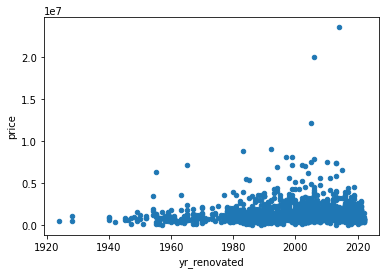

In [21]:
df_reno.plot.scatter('yr_renovated', 'price')

In [22]:
#********************PRICE FILTER**********************
# df = df[df['price'] < 2000000]
# df = df[df['sqft_living'] < 4000]

# df = df[df['yr_built'] > 2000]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8338 entries, 3 to 30153
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             8338 non-null   int64         
 1   date           8338 non-null   datetime64[ns]
 2   price          8338 non-null   float64       
 3   bedrooms       8338 non-null   int64         
 4   bathrooms      8338 non-null   float64       
 5   sqft_living    8338 non-null   int64         
 6   sqft_lot       8338 non-null   int64         
 7   floors         8338 non-null   float64       
 8   waterfront     8338 non-null   object        
 9   greenbelt      8338 non-null   object        
 10  nuisance       8338 non-null   object        
 11  view           8338 non-null   object        
 12  condition      8338 non-null   object        
 13  grade          8338 non-null   object        
 14  heat_source    8338 non-null   object        
 15  sewer_system   8338 

In [24]:
df_num = df.select_dtypes(include=np.number).drop('id', axis=1)

In [25]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8338 entries, 3 to 30153
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          8338 non-null   float64
 1   bedrooms       8338 non-null   int64  
 2   bathrooms      8338 non-null   float64
 3   sqft_living    8338 non-null   int64  
 4   sqft_lot       8338 non-null   int64  
 5   floors         8338 non-null   float64
 6   sqft_above     8338 non-null   int64  
 7   sqft_basement  8338 non-null   int64  
 8   sqft_garage    8338 non-null   int64  
 9   sqft_patio     8338 non-null   int64  
 10  yr_built       8338 non-null   int64  
 11  yr_renovated   8338 non-null   int64  
 12  lat            8338 non-null   float64
 13  long           8338 non-null   float64
 14  year           8338 non-null   int64  
dtypes: float64(5), int64(10)
memory usage: 1.0 MB


In [26]:
y = df_num['price']
X = df_num.drop(['lat','price', 'long'], axis=1)

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8338 entries, 3 to 30153
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       8338 non-null   int64  
 1   bathrooms      8338 non-null   float64
 2   sqft_living    8338 non-null   int64  
 3   sqft_lot       8338 non-null   int64  
 4   floors         8338 non-null   float64
 5   sqft_above     8338 non-null   int64  
 6   sqft_basement  8338 non-null   int64  
 7   sqft_garage    8338 non-null   int64  
 8   sqft_patio     8338 non-null   int64  
 9   yr_built       8338 non-null   int64  
 10  yr_renovated   8338 non-null   int64  
 11  year           8338 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 846.8 KB


<bound method Figure.tight_layout of <Figure size 1080x1080 with 16 Axes>>

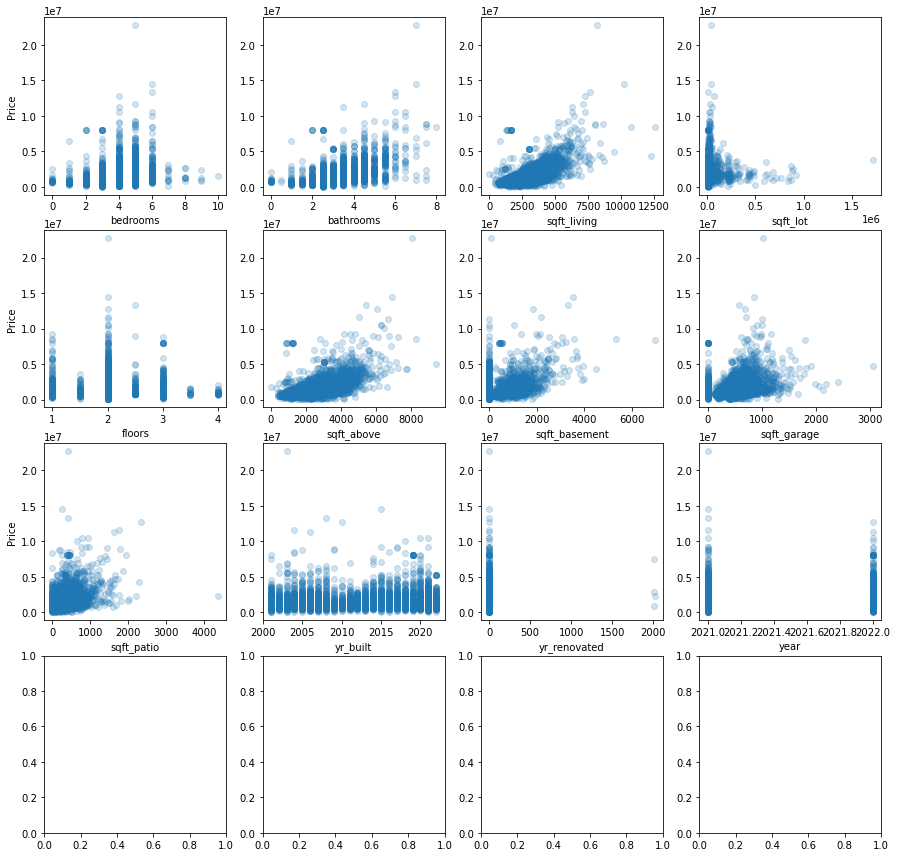

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

for i, column in enumerate(X.columns):
    row = i // 4
    col = i % 4
    ax = axes[row][col]
    
    ax.scatter(X[column], y, alpha=0.2)
    ax.set_xlabel(column)
    if col == 0:
        ax.set_ylabel('Price')
        
fig.tight_layout
        

In [29]:
len(df[df['bedrooms'] > 5])

165

***MAYBE FOR BASELINE model calculate all the correlation coefficients and see which ones best align??***

POTENTIAL NUMERIC PREDICTORS
- sqft_living (***TOP***)
- sqft_patio (are there some without patios??)
- sqft_garage
- sqft_lot (looks like some are concentrated around 0...maybe some don't have land)

Question
- How to handle bedrooms/bathrooms/floors etc...are these discrete?
- How should I go about looking at the other discrete options??

Next tier
- yr_built
- yr_renovated (may need to eliminate a lot of data)

In [30]:
#on average looks like sqft_above, sqft basement = sqft_living
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,year
count,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000
mean,3.536580,2.837671,2464.987047,1.108049e+04,2.103142,2255.705565,313.625690,397.170664,235.783161,2013.061286,0.964500,2021.346006
std,1.018089,0.825158,1121.441033,4.950606e+04,0.442752,1036.647374,504.713624,273.648196,229.575619,7.025098,44.027685,0.475724
min,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,2001.000000,0.000000,2021.000000
25%,3.000000,2.500000,1557.000000,1.488000e+03,2.000000,1350.000000,0.000000,220.000000,70.000000,2006.000000,0.000000,2021.000000
50%,4.000000,2.500000,2330.000000,4.540500e+03,2.000000,2220.000000,0.000000,420.000000,190.000000,2015.000000,0.000000,2021.000000
75%,4.000000,3.500000,3120.000000,6.998750e+03,2.000000,2958.750000,510.000000,540.000000,320.000000,2020.000000,0.000000,2022.000000
max,10.000000,8.000000,12540.000000,1.722798e+06,4.000000,9440.000000,6970.000000,3050.000000,4370.000000,2022.000000,2016.000000,2022.000000


In [31]:
X = df_num['sqft_living']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     6902.
Date:                Mon, 26 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:15:05   Log-Likelihood:            -1.2469e+05
No. Observations:                8338   AIC:                         2.494e+05
Df Residuals:                    8336   BIC:                         2.494e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.558e+05      2e+04    -12.800      

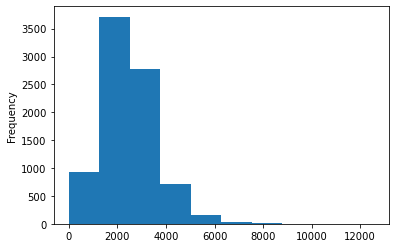

In [32]:
X.plot.hist();

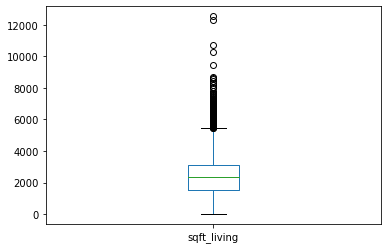

In [33]:
X.plot.box();

In [34]:
X_filt = df_num[['sqft_living', 'price']]
X_filt = X_filt[X_filt['sqft_living'] < 5000]

X_filt.head()

,sqft_living,price
3,2160,775000.0
4,1120,592500.0
7,2214,820000.0
9,2980,975000.0
12,1280,750000.0


In [35]:
y = X_filt['price']
X_filt = X_filt['sqft_living']


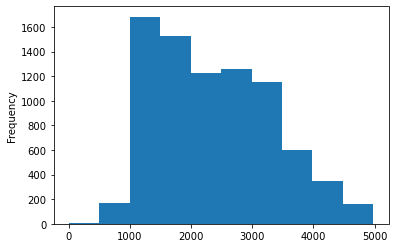

In [36]:
X_filt.plot.hist();

In [37]:
model = sm.OLS(y, sm.add_constant(X_filt))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     4470.
Date:                Mon, 26 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:15:05   Log-Likelihood:            -1.1976e+05
No. Observations:                8125   AIC:                         2.395e+05
Df Residuals:                    8123   BIC:                         2.395e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.154e+04   1.81e+04      2.290      

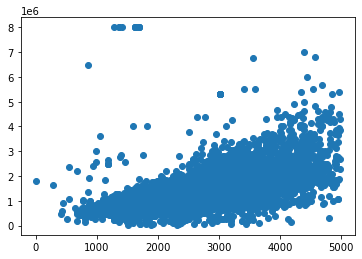

In [38]:
plt.scatter(X_filt, y)

Removing outliers from sqft didn't help baseline model

END PRACTICE

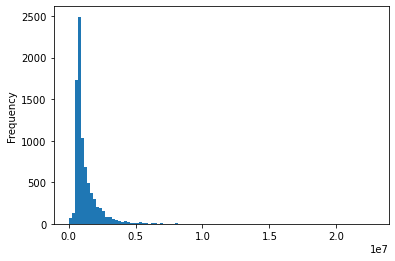

In [39]:
df["price"].plot.hist(bins=100);

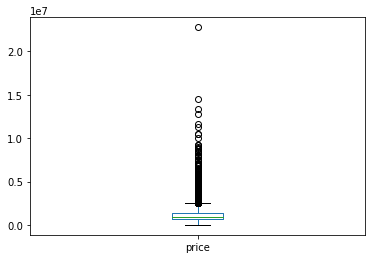

In [40]:
df["price"].plot.box();

In [41]:
# df = df[df["price"]<2500000]

#FILTERING OUTLIERS MADE THE MODELS WORSE

In [42]:
# df["price"].plot.hist(bins=50);

In [43]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,year
count,8.338000e+03,8.338000e+03,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000
mean,4.733725e+09,1.255410e+06,3.536580,2.837671,2464.987047,1.108049e+04,2.103142,2255.705565,313.625690,397.170664,235.783161,2013.061286,0.964500,46.771984,-118.989123,2021.346006
std,2.961704e+09,1.021578e+06,1.018089,0.825158,1121.441033,4.950606e+04,0.442752,1036.647374,504.713624,273.648196,229.575619,7.025098,44.027685,2.618640,10.463207,0.475724
min,7.200108e+06,2.756300e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,2001.000000,0.000000,21.274240,-157.791480,2021.000000
25%,2.211400e+09,7.200000e+05,3.000000,2.500000,1557.000000,1.488000e+03,2.000000,1350.000000,0.000000,220.000000,70.000000,2006.000000,0.000000,47.356796,-122.305318,2021.000000
50%,3.920030e+09,9.000000e+05,4.000000,2.500000,2330.000000,4.540500e+03,2.000000,2220.000000,0.000000,420.000000,190.000000,2015.000000,0.000000,47.537175,-122.175928,2021.000000
75%,7.625701e+09,1.433649e+06,4.000000,3.500000,3120.000000,6.998750e+03,2.000000,2958.750000,510.000000,540.000000,320.000000,2020.000000,0.000000,47.650987,-122.022961,2022.000000
max,9.895000e+09,2.275000e+07,10.000000,8.000000,12540.000000,1.722798e+06,4.000000,9440.000000,6970.000000,3050.000000,4370.000000,2022.000000,2016.000000,64.824070,-70.074340,2022.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8338 entries, 3 to 30153
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             8338 non-null   int64         
 1   date           8338 non-null   datetime64[ns]
 2   price          8338 non-null   float64       
 3   bedrooms       8338 non-null   int64         
 4   bathrooms      8338 non-null   float64       
 5   sqft_living    8338 non-null   int64         
 6   sqft_lot       8338 non-null   int64         
 7   floors         8338 non-null   float64       
 8   waterfront     8338 non-null   object        
 9   greenbelt      8338 non-null   object        
 10  nuisance       8338 non-null   object        
 11  view           8338 non-null   object        
 12  condition      8338 non-null   object        
 13  grade          8338 non-null   object        
 14  heat_source    8338 non-null   object        
 15  sewer_system   8338 

In [45]:
categoricals = df.select_dtypes("object")

for col in categoricals:
    print(df[col].value_counts(), "\n")

NO     8275
YES      63
Name: waterfront, dtype: int64 

NO     7945
YES     393
Name: greenbelt, dtype: int64 

NO     7046
YES    1292
Name: nuisance, dtype: int64 

NONE         7690
AVERAGE       357
GOOD          174
EXCELLENT      90
FAIR           27
Name: view, dtype: int64 

Average      8037
Good          263
Very Good      38
Name: condition, dtype: int64 

8 Good           4005
9 Better         2141
7 Average        1284
10 Very Good      628
11 Excellent      190
12 Luxury          48
6 Low Average      31
13 Mansion         11
Name: grade, dtype: int64 

Gas                  6512
Electricity          1769
Gas/Solar              28
Electricity/Solar      23
Other                   3
Oil                     3
Name: heat_source, dtype: int64 

PUBLIC                7964
PRIVATE                369
PUBLIC RESTRICTED        3
PRIVATE RESTRICTED       2
Name: sewer_system, dtype: int64 

Avenue, 108 Foothill Blvd, Rancho Cucamonga, California 91730, United States    38
Delridge 

In [46]:
categoricals = categoricals.drop(labels = ["address", "date"], axis=1)

KeyError: "['date'] not found in axis"

In [ ]:
numerical_rank = df.corr()["price"].sort_values(ascending=False)
numerical_rank

In [ ]:
df.plot.scatter("sqft_living", "price");

In [ ]:
y = df["price"]
X_baseline = df[["sqft_living"]]

In [ ]:
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

In [ ]:
cat_features = categoricals.columns
cat_features 

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 30))

for index, feature in enumerate(cat_features):
    row = index//3
    col = index%3
    df.groupby(feature).mean().sort_values(by='price').plot.bar(y="price", ax=ax[row][col])

fig.tight_layout

In [ ]:
def label_grade (row):
    if row["grade"] in ["2 Substandard", "3 Poor", "5 Fair", "4 Low", "6 Low Average"]:
        return "2 Substd. - 6 Low Ave."
    if row["grade"] in ["7 Average", "8 Good"]:
        return "7 Ave. - 8 Good"
    if row["grade"] in ["9 Better", "10 Very Good"]:
        return "9 Better - 10 Very Gd."
    if row["grade"] in ["11 Excellent", "12 Luxary", "13 Mansion"]:
        return "11 Ex - 13 Masion"
    
df['grade_group'] = df.apply(lambda row: label_grade(row), axis=1)
    

In [ ]:
df.groupby("grade_group").mean().sort_values(by='price').plot.bar(y="price")
df.groupby("grade_group").count().sort_values(by='price').plot.bar(y='id')

In [ ]:
df.groupby("grade_group").count().sort_values(by='price').plot.bar(y='id')

TO DO: Lookup the section of graphing the categories in color...what was that about again??

Potentially group grade into different categories

In [ ]:
cat_col_1 = "condition"
X_1 = df[["sqft_living", cat_col_1]]
X_1

In [ ]:
X_1 = pd.get_dummies(X_1, columns = [cat_col_1])
X_1

In [ ]:
X_1.drop("condition_Average", axis=1, inplace=True)

In [ ]:
model_1 = sm.OLS(y, sm.add_constant(X_1))
results_1 = model_1.fit()
print(results_1.summary())

In [ ]:
cat_col_2 = 'view'
X_2 = df[["sqft_living", cat_col_2]]
X_2 = pd.get_dummies(X_2, columns = [cat_col_2])
X_2

In [ ]:
X_2.drop("view_AVERAGE", axis=1, inplace=True)

model_2 = sm.OLS(y, sm.add_constant(X_2))
results_2 = model_2.fit()
print(results_2.summary())

In [ ]:
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,5))
# df.plot.scatter(x="sqft_living", y="price", c="view", cmap="plasma", alpha=0.5, ax=ax)

sns.scatterplot(x='sqft_living', y='price', data=df, hue='view');

In [ ]:
X_2_interaction = df[["sqft_living", cat_col_2]]
X_2_interaction = pd.get_dummies(X_2_interaction, columns = [cat_col_2])
X_2_interaction

In [ ]:
X_2_interaction['sqft x exc_view'] = X_2_interaction["sqft_living"] * X_2_interaction["view_EXCELLENT"]


In [ ]:
X_2_interaction.drop("view_AVERAGE", axis=1, inplace=True)

model_2_interaction = sm.OLS(y, sm.add_constant(X_2_interaction))
results_2_interaction = model_2_interaction.fit()
print(results_2_interaction.summary())

In [ ]:
cat_col_3 = 'waterfront'
X_3 = df[["sqft_living", cat_col_3]]
X_3 = pd.get_dummies(X_3, columns = [cat_col_3])
X_3

In [ ]:
X_3.drop("waterfront_NO", axis=1, inplace=True)

model_3 = sm.OLS(y, sm.add_constant(X_3))
results_3 = model_3.fit()
print(results_3.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='sqft_living', y='price', data=df, hue='waterfront');

In [ ]:
X_3_interaction = df[["sqft_living", cat_col_3]]
X_3_interaction = pd.get_dummies(X_3_interaction, columns = [cat_col_3])
X_3_interaction

In [ ]:
X_3_interaction['sqft x wf_yes'] = X_3_interaction["sqft_living"] * X_3_interaction["waterfront_YES"]


In [ ]:
X_3_interaction.drop("waterfront_NO", axis=1, inplace=True)

model_3_interaction = sm.OLS(y, sm.add_constant(X_3_interaction))
results_3_interaction = model_3_interaction.fit()
print(results_3_interaction.summary())

In [ ]:
X_4 = df[["sqft_living", cat_col_3, cat_col_2]]
X_4 = pd.get_dummies(X_4, columns = [cat_col_3, cat_col_2])
X_4

In [ ]:
X_4.drop(["waterfront_NO", 'view_AVERAGE'], axis=1, inplace=True)

model_4 = sm.OLS(y, sm.add_constant(X_4))
results_4 = model_4.fit()
print(results_4.summary())

In [ ]:
cat_col_5 = 'grade_group'
X_5 = df[["sqft_living", cat_col_5]]
X_5 = pd.get_dummies(X_5, columns = [cat_col_5])
X_5

In [ ]:
X_5.drop("grade_group_2 Substd. - 6 Low Ave.", axis=1, inplace=True)

model_5 = sm.OLS(y, sm.add_constant(X_5))
results_5 = model_5.fit()
print(results_5.summary())

#NOT FOLLOWING WHY 7 - 8 is negative coeff in relation to 2-6...think it's cause qty's vary b/w groups

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='sqft_living', y='price', data=df, hue='grade_group');

In [ ]:
X_6 = df[["sqft_living", cat_col_5, cat_col_2]]
X_6 = pd.get_dummies(X_6, columns = [cat_col_5, cat_col_2])
X_6

In [ ]:
X_6.drop(["view_AVERAGE", 'grade_group_2 Substd. - 6 Low Ave.'], axis=1, inplace=True)

model_6 = sm.OLS(y, sm.add_constant(X_6))
results_6 = model_6.fit()
print(results_6.summary())

In [ ]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_6,
    exog_idx=list(X_6.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

In [ ]:
X_7 = df[["sqft_living", cat_col_5, cat_col_2, cat_col_3]]
X_7 = pd.get_dummies(X_7, columns = [cat_col_5, cat_col_2, cat_col_3])
X_7

In [ ]:
X_7.drop(["view_AVERAGE", 'grade_group_2 Substd. - 6 Low Ave.', "waterfront_NO"], axis=1, inplace=True)

model_7 = sm.OLS(y, sm.add_constant(X_7))
results_7 = model_7.fit()
print(results_7.summary())

In [ ]:
X_7 = df[["sqft_living", cat_col_5, cat_col_2, cat_col_3]]
X_7 = pd.get_dummies(X_7, columns = [cat_col_5, cat_col_2, cat_col_3])
X_7

In [ ]:
X_7.drop(["view_AVERAGE", 'grade_group_2 Substd. - 6 Low Ave.', "waterfront_NO"], axis=1, inplace=True)

model_7 = sm.OLS(y, sm.add_constant(X_6))
results_7 = model_6.fit()
print(results_7.summary())

In [ ]:
X_8 = df[["sqft_living", cat_col_5, cat_col_2, cat_col_3, cat_col_1]]
X_8 = pd.get_dummies(X_8, columns = [cat_col_5, cat_col_2, cat_col_3, cat_col_1])
X_8

In [ ]:
X_8.drop(["view_AVERAGE", 'grade_group_2 Substd. - 6 Low Ave.', "waterfront_NO", "condition_Average"], axis=1, inplace=True)

model_8 = sm.OLS(y, sm.add_constant(X_8))
results_8 = model_8.fit()
print(results_8.summary())

REVISIT NUMERICAL...LOG, etc.

In [ ]:
print(baseline_results.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=X, y=y, label="Data points")
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax)
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(X, baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("Sqft living")
ax.set_ylabel("residuals");

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan


het_breuschpagan(baseline_results.resid, sm.add_constant(X))

In [ ]:
numerical_rank

In [ ]:
X_sqft_br = df[["sqft_living", "bedrooms"]]
model_sqft_br = sm.OLS(y, sm.add_constant(X_sqft_br))
results_sqft_br = model_sqft_br.fit()

print(results_sqft_br.summary())

#I actually think bedroom should be categorical

In [ ]:
df['sqft_living'].plot.hist(bins=50)

In [ ]:
X_sqft_log = X_baseline.copy()
X_sqft_log['log(sqft_living)'] = np.log(X_sqft_log['sqft_living'])
X_sqft_log

In [ ]:
X_sqft_log

In [ ]:
y

In [ ]:
X_sqft_log.drop('sqft_living', axis=1, inplace=True)

model_sqft_log = sm.OLS(y, sm.add_constant(X_sqft_log))
results_sqft_log = model_sqft_log.fit()

print(results_sqft_log.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=X_sqft_log, y=y, label="Data points")
sm.graphics.abline_plot(model_results=results_sqft_log, label="Regression line", ax=ax)
ax.legend();

In [ ]:
y_log = np.log(y)
y_log.name = 'log(price)'
y_log

In [ ]:
model_price_log = sm.OLS(y_log, sm.add_constant(X))
results_price_log = model_price_log.fit()

print(results_price_log.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=X, y=y_log, label="Data points")
sm.graphics.abline_plot(model_results=results_price_log, label="Regression line", ax=ax)
ax.legend();

In [ ]:
X

In [ ]:
fig, ax = plt.subplots()

ax.scatter(X, results_price_log.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("Sqft living")
ax.set_ylabel("residuals");

In [ ]:
het_breuschpagan(results_price_log.resid, sm.add_constant(df['sqft_living']))

In [ ]:
model_sqft_price_log = sm.OLS(y_log, sm.add_constant(X_sqft_log))
results_sqft_price_log = model_sqft_price_log.fit()

print(results_sqft_price_log.summary())

Lat/Long check

In [ ]:
df.info()

In [ ]:
df[['lat', 'long']].describe()

In [ ]:
df['lat'].head()

In [ ]:
df['lat']


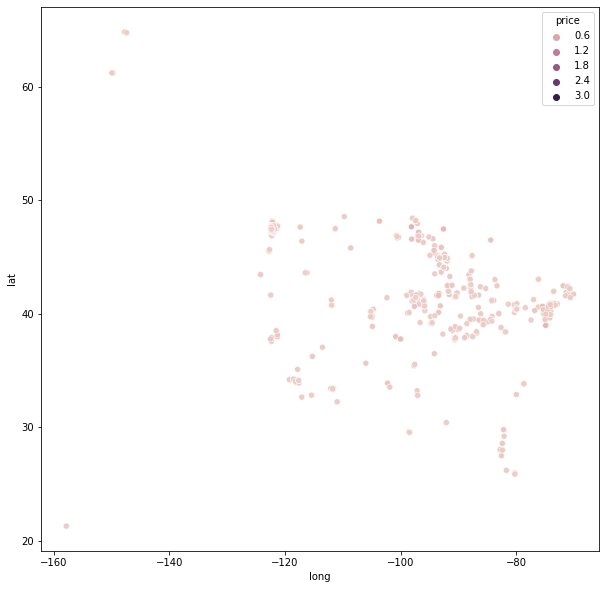

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='long', y='lat', data=df, hue='price');



In [ ]:
df.plot.scatter(y='price', x='long')

In [ ]:
X_loc = df[['lat', 'long']]

In [ ]:
model_loc = sm.OLS(y, sm.add_constant(X_loc))
results_loc = model_loc.fit()

print(results_loc.summary())

In [ ]:
# url = "https://api.mapbox.com/geocoding/v5/mapbox.places/-122.1,47.37.json?access_token=pk.eyJ1IjoicHBhcmtpbnNvbiIsImEiOiJjbGJ6cDR3eW8xMndtM3BwajU5ZGIwbjd3In0.krj0bzOrWhxQiEHZ2w5-IQ"
# url = "https://api.mapbox.com/geocoding/v5/mapbox.places/-122.32940,47.664740.json?types=neighborhood&access_token=pk.eyJ1IjoicHBhcmtpbnNvbiIsImEiOiJjbGJ6cDR3eW8xMndtM3BwajU5ZGIwbjd3In0.krj0bzOrWhxQiEHZ2w5-IQ"
# response = requests.get(url)

In [ ]:
# response

In [ ]:
# response.json()

In [ ]:
# response.json()['features'][0]['text']

In [ ]:
# response.json()['features'][0]['text']

In [ ]:
# df.head()

In [ ]:
pd.set_option('display.max_colwidth', None)
df.address

In [ ]:
df[['Street', 'City', 'State_Zip', 'Country', 'Extra_1', 'Extra_2']] = df['address'].str.split(',', expand = True)

In [ ]:
print(df['State_Zip'])

In [ ]:
# df['State_Zip'] = df['State_Zip'].str.split()

In [ ]:
# df['State_Zip']

In [ ]:
# df[['State 1', 'State 2', 'Zip']] = df['State_Zip'].str.split(',', expand = True)

In [ ]:
# def slice_zip(row):
#     return row['State_Zip'][-5:]

df['zip'] = df.apply(lambda row: row['State_Zip'][-5:], axis=1)

In [ ]:
df['zip']

In [ ]:
df.groupby('zip').count()

In [ ]:
pd.set_option('display.max_rows', None)
df['zip'].value_counts() 

In [ ]:
# df = df[df.zip != 'City']

df = df[~df['zip'].str.contains("[a-zA-Z]").fillna(False)]
#INVESTIGATE WHY THIS WORKS

In [ ]:
len(df['zip'].value_counts())

In [ ]:
df.groupby('zip').count()

In [ ]:
#may want adjust required sample size per zip code

df = df[df['zip'].map(df['zip'].value_counts()) > 100]

In [ ]:
df_zip_mean = df.groupby('zip', as_index=False).mean()

In [ ]:
len(df)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

# df.groupby('zip').mean().sort_values('price', ascending=False)['price']
df.groupby('zip').mean().sort_values('price', ascending=False).plot.bar(y='price', ax=ax);
plt.axhline(2500000, color='black')
plt.axhline(1600000, color='black')
plt.axhline(1100000, color='black')
plt.axhline(700000, color='black')

IN FUTURE, ADD CUTOFFS TO VISUALIZATION

In [ ]:
df_zip_mean.head()

In [ ]:
def label_zip (row):   
    if row['price'] > 2500000:
        return "Tier_1_zip"
    if (row['price'] < 2500000) & (row['price'] > 1600000):
        return "Tier_2_zip"
    if (row['price'] < 1600000) & (row['price'] > 1100000):
        return "Tier_3_zip"
    if (row['price'] < 1100000) & (row['price'] > 700000):
        return "Tier_4_zip"
    if row['price'] < 700000:
        return "Tier_5_zip"
    
df_zip_mean['zip_tier'] = df_zip_mean.apply(lambda row: label_zip(row), axis=1)



In [ ]:
df_zip_mean['zip_tier'].value_counts()

In [ ]:
df_zip_mean = df_zip_mean[['zip', 'zip_tier']]
df_zip_mean

DIDN'T I REMOVE ZIP CODES WITH ENTRIES < 100?...HOW CAN TIER 5 BY THAT LOW

In [ ]:
df = df_zip_mean.merge(df, how='inner', 
                                    left_on='zip', 
                                    right_on='zip')

df.head()

In [ ]:
len(df)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

# df.groupby('zip').mean().sort_values('price', ascending=False)['price']
df.groupby('zip_tier').mean().sort_values('price', ascending=False).plot.bar(y='price', ax=ax);


In [ ]:
X_9 = df[['sqft_living', 'zip_tier']]
X_9 = pd.get_dummies(X_9, columns = ['zip_tier'])

y = df['price']

X_9.head()

In [ ]:
X_9.drop(['zip_tier_Tier_5_zip'], axis=1, inplace=True)

model_9 = sm.OLS(y, sm.add_constant(X_9))
results_9 = model_9.fit()
print(results_9.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='sqft_living', y='price', data=df, hue='zip_tier', alpha=.5);

In [ ]:
X_10 = df[['sqft_living', 'zip_tier', cat_col_5]]
X_10 = pd.get_dummies(X_10, columns = ['zip_tier', cat_col_5])

X_10.drop(['zip_tier_Tier_5_zip', 'grade_group_2 Substd. - 6 Low Ave.'], axis=1, inplace=True)

model_10 = sm.OLS(y, sm.add_constant(X_10))
results_10 = model_10.fit()
print(results_10.summary())

In [ ]:
X_11 = df[['sqft_living', 'zip_tier', cat_col_3]]
X_11 = pd.get_dummies(X_11, columns = ['zip_tier', cat_col_3])

X_11.drop(['zip_tier_Tier_5_zip', "waterfront_NO"], axis=1, inplace=True)

model_11 = sm.OLS(y, sm.add_constant(X_11))
results_11 = model_11.fit()
print(results_11.summary())

In [ ]:
X_12 = df[['sqft_living', 'zip_tier', cat_col_2]]
X_12 = pd.get_dummies(X_12, columns = ['zip_tier', cat_col_2])

X_12.drop(['zip_tier_Tier_5_zip', "view_AVERAGE"], axis=1, inplace=True)

model_12 = sm.OLS(y, sm.add_constant(X_12))
results_12 = model_12.fit()
print(results_12.summary())

In [ ]:
df_br = df[df['bedrooms'] < 5]
df_br.info()

In [ ]:
y_br = df_br['price']

In [ ]:
X_14 = df_br[['sqft_living', 'zip_tier', 'bedrooms']]

In [ ]:

X_14 = pd.get_dummies(X_14, columns = ['zip_tier', 'bedrooms'])
X_14.head()

In [ ]:
X_14.drop(['zip_tier_Tier_5_zip', 'bedrooms_1'], axis=1, inplace=True)



In [ ]:
model_14 = sm.OLS(y_br, sm.add_constant(X_14))
results_14 = model_14.fit()
print(results_14.summary())